# 🌱🌱🌱 **The Invisible Carbon Calculator** 🌱🌱🌱

---

### *Uncover the carbon footprint you can’t see—at home, on the road, and online.*

---

#### **What is Invisible Carbon?**  
🧭🌍🚀  
**Next-gen calculator:**  
- 🍔 Food  
- 🚗 Travel  
- 💡 Energy  
- 📱 Digital Life (Streaming 🎬, Scrolling 📲, Cloud ☁️, Notifications 🔔)

---

#### **How It Works**
🔢 ➡️ 📊 ➡️ 🤖✨

1️⃣ **Input habits**  
2️⃣ **See instant, interactive charts**  
3️⃣ **Get AI-powered, personalized tips**  

---

#### **Features**  
- 📊 **Live visualizations**
- 🤖 **Smart AI suggestions**
- 🚦 **Digital + daily life**
- 🛡️ **Privacy-first**

---

#### **Why Invisible Carbon?**
> 🌫️ **Others miss your digital life**—Invisible Carbon reveals it!  
> 🌱 **See the full story. Make real change.**

---

✨ *Discover the unseen.  
🌎 Act for the planet.  
⚡️ Make every click count!* ✨

---



###**Set-Up**

In [22]:
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from IPython.display import Markdown
from google.colab import userdata

GEMINI_API_KEY = userdata.get('PATEL_GEMINI_KEY')

###**Data and Variables Collection**

In [23]:
"""========== EMISSION FACTORS (kg CO2e) - VERIFIED SOURCES ==========="""
# Transportation Sources: EPA, EEA, ICAO

TRANSPORT_FACTORS = {
    "gasoline_car": 0.192,          # per km (EPA)
    "diesel_car": 0.171,             # per km (EEA)
    "electric_car": 0.053,           # per km (IEA global electricity mix)
    "bus": 0.089,                    # per km (UITP)
    "train": 0.041,                  # per km (UIC)
    "short_flight": 0.25,            # per km (ICAO <500km)
    "long_flight": 0.18,             # per km (ICAO >500km)
    "motorbike": 0.113               # per km (EEA)
}

# Dietary Sources: Poore & Nemecek (Science, 2018)
DIET_FACTORS = {
    "meat_heavy": 2.5,               # per meal
    "meat_medium": 1.8,
    "vegetarian": 1.2,
    "vegan": 0.8,
    "pescatarian": 1.5
}

# Household Sources: IEA, IPCC, Water Footprint Network
HOUSEHOLD_FACTORS = {
    "electricity": 0.5,              # per kWh (IEA global avg)
    "natural_gas": 1.89,             # per m³ (IPCC)
    "heating_oil": 2.68,             # per liter (IPCC)
    "water": 0.3,                    # per m³
    "waste": 0.1                     # per kg
}

# Digital Sources: ADEME, Shift Project, Berkeley Lab
DIGITAL_FACTORS = {
    "smartphone": 60,                # per year (ADEME)
    "laptop": 200,                   # per year (ADEME)
    "desktop": 300,                  # per year (ADEME)
    "streaming_hd": 0.06,            # per hour (Shift Project)
    "streaming_4k": 0.15,            # per hour (Shift Project)
    "social_media": 0.01,            # per hour (Shift Project)
    "cloud_storage": 0.2,            # per GB/year (Berkeley Lab)
    "email": 0.000003,               # per email (Mike Berners-Lee)
    "gaming": 0.14                   # per hour (ADEME)
}

# Global averages for comparison
GLOBAL_AVERAGES = {
    "transport": 2400,               # kg CO2e/year
    "diet": 2000,
    "household": 3000,
    "digital": 400,
    "total": 7800                    # World avg: 4.8t, US avg: 16t
}

###**Data Entry Functions**

In [24]:
def get_float(prompt, default=0.0, min_val=0.0):
    """Get float input with default value and validation"""
    while True:
        try:
            value = input(f"{prompt} [Default: {default}]: ").strip()
            if value == "":
                return default
            value = float(value)
            if value >= min_val:
                return value
            print(f"Value must be >= {min_val}")
        except ValueError:
            print("Please enter a valid number")

In [25]:
def get_choice(prompt, choices, default=None):
    """Get choice from a list of options with default"""
    choices = [c.lower() for c in choices]
    default = default.lower() if default else choices[0]

    while True:
        choice = input(f"{prompt} [{'/'.join(choices)}] (Default: {default}): ").lower().strip()
        if choice == "":
            return default
        if choice in choices:
            return choice
        print(f"Invalid choice. Please choose from: {', '.join(choices)}")

In [26]:
def get_mode():
    """Get calculation mode with default"""
    return get_choice(
        "\nChoose calculation mode:",
        choices=["1", "2"],
        default="1"
    )

In [27]:
def get_transport_input():
    """Get transportation data with sensible defaults"""
    print("\n" + "-"*20 + " TRANSPORT " + "-"*20)
    car_type = get_choice(
        "Main vehicle type?",
        choices=["gasoline", "diesel", "electric", "none"],
        default="none"
    )

    car_km = 0.0
    if car_type != "none":
        car_km = get_float("Weekly km driven:", default=50.0)

    flights = {
        "short_flights": get_float("Annual short flights (<500km)?", default=0.0),
        "long_flights": get_float("Annual long flights (>500km)?", default=0.0)
    }

    return {
        "car_type": car_type,
        "car_km": car_km,
        **flights
    }

In [28]:
def get_diet_input():
    """Get dietary data with sensible defaults"""
    print("\n" + "-"*20 + " DIET " + "-"*20)
    diet_type = get_choice(
        "Diet type?",
        choices=["meat_heavy", "meat_medium", "pescatarian", "vegetarian", "vegan"],
        default="meat_medium"
    )
    meals_per_day = get_float("Meals per day:", default=3.0, min_val=1.0)
    return {
        "diet_type": diet_type,
        "meals_per_day": meals_per_day
    }

In [29]:
def get_household_input():
    """Get household data with sensible defaults"""
    print("\n" + "-"*20 + " HOUSEHOLD " + "-"*20)
    return {
        "electricity": get_float("Monthly electricity (kWh):", default=150.0),
        "gas": get_float("Monthly natural gas (m³) or heating oil (liters):", default=80.0),
        "water": get_float("Monthly water usage (m³):", default=10.0)
    }

In [30]:
def get_digital_input():
    """Get digital data with sensible defaults"""
    print("\n" + "-"*20 + " DIGITAL LIFE " + "-"*20)
    return {
        "devices": {
            "smartphones": get_float("Number of smartphones:", default=1.0),
            "laptops": get_float("Number of laptops:", default=1.0),
            "desktops": get_float("Number of desktops:", default=0.0)
        },
        "streaming_hrs": get_float("Weekly video streaming hours:", default=10.0),
        "streaming_quality": get_choice("Primary streaming quality?", ["hd", "4k"], "hd"),
        "social_media_hrs": get_float("Daily social media hours:", default=2.0),
        "cloud_storage": get_float("Cloud storage used (GB):", default=50.0),
        "emails": get_float("Daily emails received:", default=50.0),
        "gaming_hrs": get_float("Weekly gaming hours:", default=5.0)
    }

###**Footprint Calculations Fns**

In [31]:
def calculate_transport(data):
    """Calculate transport emissions with fallbacks"""
    emissions = 0.0

    # Car emissions
    if data["car_type"] != "none":
        factor_key = f"{data['car_type']}_car"
        if factor_key in TRANSPORT_FACTORS:
            emissions += data["car_km"] * 52 * TRANSPORT_FACTORS[factor_key]

    # Flight emissions
    emissions += data["short_flights"] * TRANSPORT_FACTORS["short_flight"]
    emissions += data["long_flights"] * TRANSPORT_FACTORS["long_flight"]

    return emissions

In [32]:
def calculate_diet(data):
    """Calculate diet emissions with fallbacks"""
    if data["diet_type"] in DIET_FACTORS:
        return data["meals_per_day"] * 365 * DIET_FACTORS[data["diet_type"]]
    return 0.0  # Fallback for unknown diet

In [33]:
def calculate_household(data):
    """Calculate household emissions with fallbacks"""
    electricity = data["electricity"] * 12 * HOUSEHOLD_FACTORS["electricity"]
    gas = data["gas"] * 12 * HOUSEHOLD_FACTORS["natural_gas"]
    water = data["water"] * 12 * HOUSEHOLD_FACTORS["water"]
    return electricity + gas + water

In [34]:
def calculate_digital(data):
    """Calculate digital emissions with fallbacks"""
    emissions = 0.0

    # Device emissions
    for device, count in data["devices"].items():
        factor_key = device.rstrip('s')  # Convert "smartphones" to "smartphone"
        if factor_key in DIGITAL_FACTORS:
            emissions += count * DIGITAL_FACTORS[factor_key]

    # Streaming
    quality = "streaming_4k" if data["streaming_quality"] == "4k" else "streaming_hd"
    if quality in DIGITAL_FACTORS:
        emissions += data["streaming_hrs"] * 52 * DIGITAL_FACTORS[quality]

    # Other digital activities
    emissions += data["social_media_hrs"] * 365 * DIGITAL_FACTORS["social_media"]
    emissions += data["cloud_storage"] * DIGITAL_FACTORS["cloud_storage"]
    emissions += data["emails"] * 365 * DIGITAL_FACTORS["email"]
    emissions += data["gaming_hrs"] * 52 * DIGITAL_FACTORS["gaming"]

    return emissions

###**Visualisation Fns**

In [35]:
def visualize_results(footprint_data):
    """Create adaptive visualization that handles zeros and small values"""
    # Prepare data for pie chart
    categories = []
    sizes = []
    colors = []

    # Add only categories with non-zero emissions
    if footprint_data['transport'] > 0:
        categories.append('Transport')
        sizes.append(footprint_data['transport'])
        colors.append('#ff9999')

    if footprint_data['diet'] > 0:
        categories.append('Diet')
        sizes.append(footprint_data['diet'])
        colors.append('#66b3ff')

    if footprint_data['household'] > 0:
        categories.append('Household')
        sizes.append(footprint_data['household'])
        colors.append('#99ff99')

    if footprint_data.get('digital', 0) > 0:
        categories.append('Digital')
        sizes.append(footprint_data['digital'])
        colors.append('#ffcc99')

    # Create figure with adaptive layout
    fig = plt.figure(figsize=(12, 6))

    # Pie chart (only if we have emissions)
    if sizes:
        ax1 = fig.add_subplot(121)
        wedges, texts, autotexts = ax1.pie(
            sizes,
            labels=categories,
            colors=colors,
            autopct=lambda p: f'{p:.1f}%' if p > 5 else '',
            startangle=90
        )
        ax1.axis('equal')
        plt.setp(autotexts, size=10, weight="bold")
        plt.title('Carbon Footprint Breakdown')

        # Add legend for small slices
        if any(p < 5 for p in (np.array(sizes)/(sum(sizes)*100))):
            plt.legend(
                wedges,
                categories,
                title="Categories",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))

    # Comparison chart
    ax2 = fig.add_subplot(122)
    compare_categories = ['You', 'Global Avg']
    values = [footprint_data['total'] / 1000, GLOBAL_AVERAGES['total'] / 1000]
    bars = ax2.bar(compare_categories, values, color=['#1f77b4', '#ff7f0e'])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.1,
            f'{height:.1f}t',
            ha='center',
            va='bottom'
        )

    ax2.set_ylabel('Tonnes CO2e/year')
    ax2.set_title('Global Comparison')
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show
    plt.tight_layout()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plt.savefig(f"footprint_{timestamp}.png")
    plt.show()

###**AI suggestions Fns Using Gemini**

In [36]:
def get_ai_recommendations(footprint_data, api_key):
    """Generate recommendations using Gemini API with fallback to generic text if any error occurs."""
    breakdown = "\n".join(
        f"- {category}: {value:.1f} kg ({pct:.1f}%)"
        for category, value, pct in [
            ('Transport', footprint_data['transport'], footprint_data['transport_pct']),
            ('Diet', footprint_data['diet'], footprint_data['diet_pct']),
            ('Household', footprint_data['household'], footprint_data['household_pct']),
            ('Digital', footprint_data.get('digital', 0), footprint_data.get('digital_pct', 0))
        ] if value > 0
    )

    prompt = f"""
    Act as an environmental scientist. The user has an annual carbon footprint of {footprint_data['total']/1000:.1f} tonnes CO2e.
    Breakdown:
    {breakdown}

    Provide 3 personalized, actionable recommendations to reduce their footprint. Focus on their highest impact areas, especially digital habits. Keep it concise and practical.
    """

    fallback = (
        "1. **Reduce Meat Consumption** (Up to 500 kg CO2e/year)\n"
        "   - Replace 2 meat meals/week with vegetarian options\n"
        "   - Try plant-based dairy alternatives\n"
        "2. **Improve Home Energy Efficiency** (Up to 300 kg CO2e/year)\n"
        "   - Set thermostat lower in winter\n"
        "   - Switch to LED lighting\n"
        "   - Unplug devices when not in use\n"
        "3. **Optimize Digital Usage** (Up to 100 kg CO2e/year)\n"
        "   - Stream videos in SD when HD is not needed\n"
        "   - Unsubscribe from unnecessary emails and notifications\n"
        "   - Use cloud storage efficiently\n"
    )

    if not api_key:
        print("\nNo API key provided. Showing generic tips instead.\n")
        print(fallback)
        return fallback

    try:
        headers = {"Content-Type": "application/json"}
        payload = {
            "contents": [{"parts": [{"text": prompt}]}]
        }
        response = requests.post(
            f"https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro-latest:generateContent?key={api_key}",
            headers=headers,
            json=payload,
            timeout=10
        )
        response.raise_for_status()
        # Gemini returns a list of "candidates", each with "content", which has "parts" -> "text"
        suggestions = response.json()["candidates"][0]["content"]["parts"][0]["text"]
        print("\nAI-Generated Recommendations:\n")
        print(suggestions)
        return suggestions

    except Exception as e:
        print(f"\nAI Error: {e}. Showing generic tips instead.\n")
        print(fallback)
        return fallback

###**Main Fn**

In [37]:
def main():
    print("\n" + "="*50)
    print("CARBON FOOTPRINT CALCULATOR".center(50))
    print("="*50)

    # Get calculation mode
    mode = get_mode()

    # Collect data based on mode
    transport_data = get_transport_input()
    diet_data = get_diet_input()
    household_data = get_household_input()
    digital_data = {} if mode == "1" else get_digital_input()

    # Calculate emissions
    transport = calculate_transport(transport_data)
    diet = calculate_diet(diet_data)
    household = calculate_household(household_data)
    digital = calculate_digital(digital_data) if mode == "2" else 0

    total = transport + diet + household + digital

    # Prepare results
    footprint_data = {
        "transport": transport,
        "diet": diet,
        "household": household,
        "total": total,
        "transport_pct": (transport / total) * 100 if total > 0 else 0,
        "diet_pct": (diet / total) * 100 if total > 0 else 0,
        "household_pct": (household / total) * 100 if total > 0 else 0,
    }

    if mode == "2":
        footprint_data["digital"] = digital
        footprint_data["digital_pct"] = (digital / total) * 100 if total > 0 else 0

    # Display results
    print("\n" + "="*50)
    print("CALCULATION RESULTS".center(50))
    print("="*50)
    print(f"\n🚗 Transport: {transport:.1f} kg CO2e ({footprint_data['transport_pct']:.1f}%)")
    print(f"🍖 Diet: {diet:.1f} kg CO2e ({footprint_data['diet_pct']:.1f}%)")
    print(f"🏠 Household: {household:.1f} kg CO2e ({footprint_data['household_pct']:.1f}%)")
    if mode == "2":
        print(f"💻 Digital: {digital:.1f} kg CO2e ({footprint_data['digital_pct']:.1f}%)")
    print(f"\n✅ TOTAL ANNUAL FOOTPRINT: {total/1000:.2f} tonnes CO2e")
    print(f"🌍 Global Average: {GLOBAL_AVERAGES['total']/1000:.1f} tonnes")

    # Generate visualization
    visualize_results(footprint_data)

    get_ai_recommendations(footprint_data, GEMINI_API_KEY)


           CARBON FOOTPRINT CALCULATOR            

Choose calculation mode: [1/2] (Default: 1): 1

-------------------- TRANSPORT --------------------
Main vehicle type? [gasoline/diesel/electric/none] (Default: none): diesel
Weekly km driven: [Default: 50.0]: 50
Annual short flights (<500km)? [Default: 0.0]: 200
Annual long flights (>500km)? [Default: 0.0]: 1000

-------------------- DIET --------------------
Diet type? [meat_heavy/meat_medium/pescatarian/vegetarian/vegan] (Default: meat_medium): 
Meals per day: [Default: 3.0]: 3

-------------------- HOUSEHOLD --------------------
Monthly electricity (kWh): [Default: 150.0]: 150
Monthly natural gas (m³) or heating oil (liters): [Default: 80.0]: 20
Monthly water usage (m³): [Default: 10.0]: 20

               CALCULATION RESULTS                

🚗 Transport: 674.6 kg CO2e (16.6%)
🍖 Diet: 1971.0 kg CO2e (48.4%)
🏠 Household: 1425.6 kg CO2e (35.0%)

✅ TOTAL ANNUAL FOOTPRINT: 4.07 tonnes CO2e
🌍 Global Average: 7.8 tonnes


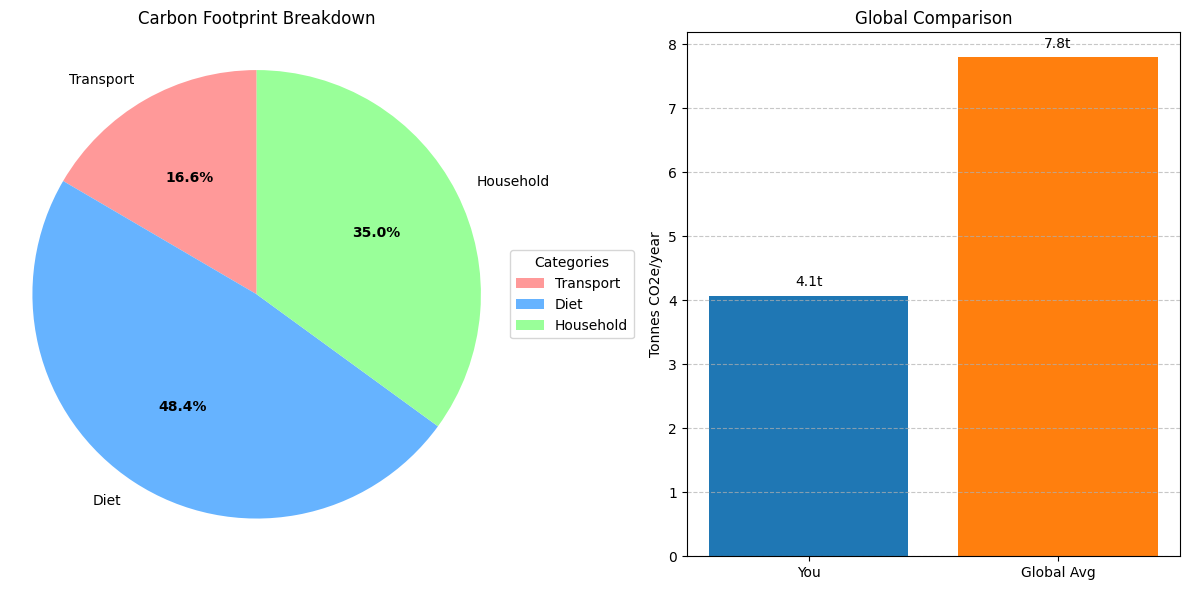


AI-Generated Recommendations:

Your diet contributes the most to your carbon footprint.  Focusing efforts there will yield the largest gains. Here are three actionable recommendations:

1. **Reduce beef consumption:**  Beef production is carbon-intensive. Aim for one beef-free day per week initially, then gradually increase it. Substitute with poultry, beans, lentils, or plant-based meat alternatives. 

2. **Minimize food waste:**  Plan meals, use leftovers creatively, and compost food scraps. Wasted food represents embedded carbon emissions released for no benefit.

3. **Streamline digital consumption:** While less impactful than diet in your case, seemingly small digital actions add up. Download files instead of streaming whenever possible (movies, music), unsubscribe from unwanted email lists to reduce data center storage, and delete unnecessary cloud-stored files. This reduces energy demand in data centers.



In [38]:
if __name__ == "__main__":
    main()

###**Thank you for using our Calculator...**